In [224]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from pathlib import Path
import matplotlib as mpl
import os
from matplotlib.lines import Line2D
from collections import Counter
import math
from sklearn.decomposition import PCA
from aging.behavior.syllables import relabel_by_usage
from tqdm import tqdm
%matplotlib inline
import warnings
warnings.simplefilter('ignore')
import random
import scipy
from sklearn.metrics import pairwise_distances
import re
from tqdm.auto import tqdm
from datetime import date

In [225]:
pd.set_option('display.max_rows', None)
pd.set_option('display.max_columns', None)
pd.set_option('display.width', None)
pd.set_option('display.max_colwidth', None)

In [226]:
# load data
path = Path('/n/groups/datta/win/longtogeny/data/ontogeny/version_05/wheel_clean.parquet')
df = pd.read_parquet(path)

In [227]:
## calculate number of runs per log file
# upload log files
folder_path = Path('/n/groups/datta/win/longtogeny/data/wheel/running_logs')
file_paths = [os.path.join(folder_path, f) for f in os.listdir(folder_path) if os.path.isfile(os.path.join(folder_path, f))]

In [228]:
def get_info(path):
     try:
         with open(path, 'r') as f:
             lines = list(map(str.strip, f.readlines()))
         name_line = [l for l in lines if 'Subject ID' in l][0]
         start_date = [l for l in lines if 'Experiment Started' in l][0]
         end_date = [l for l in lines if 'CSV Generation Date' in l][0]
         rotations = lines[-3]
         return dict(
	         name=name_line.split(',')[-1],
	         start=start_date.split(',')[-1],
	         end=end_date.split(',')[-1],
             rotations=int(rotations.split(',')[-1]),
			 file=path
		)
     except Exception:
         return dict(file=path)

In [229]:
# get the wheel rotations log to dataframe
ds=[]
for f in file_paths:
    d = get_info(f)
    ds.append(d)
rotations_df = pd.DataFrame(ds)

In [230]:
rotations_df['start'] = pd.to_datetime(rotations_df['start'])
rotations_df['end'] = pd.to_datetime(rotations_df['end'])
rotations_df['recording_duration_days'] = (rotations_df["end"] - rotations_df["start"]).dt.total_seconds() / 60 / 60 / 24
rotations_df['rotations_per_day'] = rotations_df['rotations'] / rotations_df['recording_duration_days']
rotations_df.rename(columns={'name':'cage'},inplace=True)
#rotations_df['date'] = rotations_df['end'].dt.date.astype(str)
rotations_df['date'] = rotations_df['end'].dt.date

In [231]:
# some manual curations on the rotation dataframe
# change date in 12w4 2023-07-18 to 2023-07-16
rotations_df.loc[rotations_df.date == '2023-07-18', 'date'] = date(2023, 7, 16)
# remove raws in which there is no logged data (cage was not plugged in)
rotations_df = rotations_df[~rotations_df.isna().any(axis=1)]

[Text(0.5, 0, 'Days of wheel recording')]

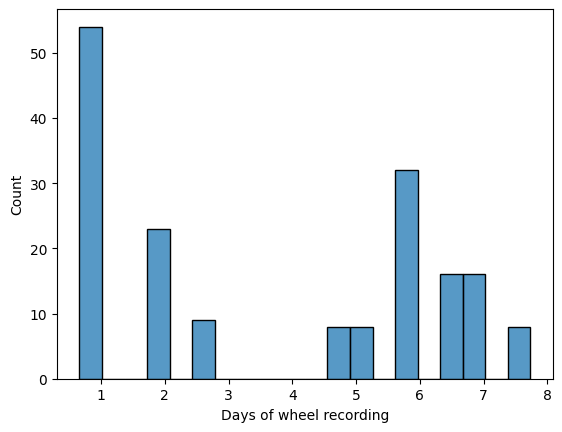

In [232]:
ax = sns.histplot(
    (rotations_df["end"] - rotations_df["start"]).dt.total_seconds() / 60 / 60 / 24,
    bins=20)
ax.set(xlabel="Days of wheel recording") 

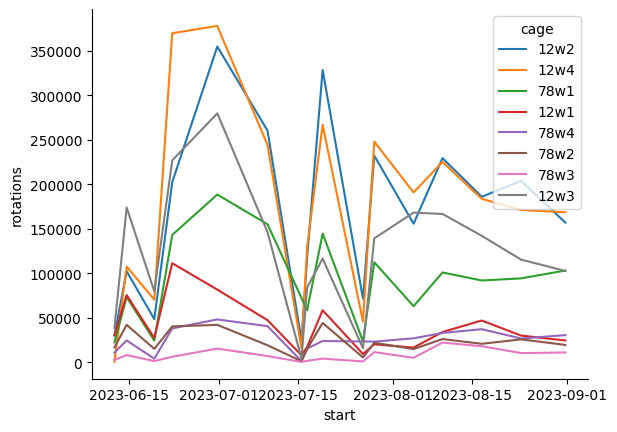

In [233]:
ax = sns.lineplot(data=rotations_df.query('recording_duration_days > 1'), x='start', y='rotations', hue='cage')
sns.despine()

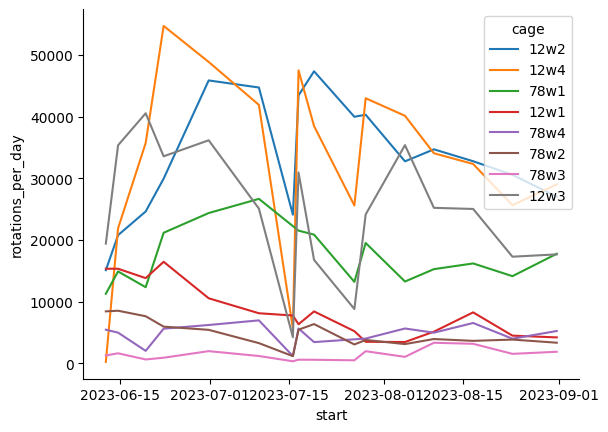

In [234]:
ax = sns.lineplot(
    data=rotations_df.query("recording_duration_days > 1"),
    x="start",
    y="rotations_per_day",
    hue="cage")
sns.despine()

In [235]:
## match data for wheel turning with syllable data
# Extract the date part (keeping only the date)
match_df = df.copy().reset_index()
# Extract the date part (keeping only the day date)
#match_df['date'] = match_df['date'].dt.date.astype(str)
match_df['date'] = match_df['date'].dt.date

In [236]:
# create a merged matrix
wheel_df = pd.merge(match_df,rotations_df,how='outer',on=['cage','date'])

In [237]:
# manual curation 

#remove sessions in which the cage was probably not logged in
bad_dates=[date(2023, 7, 28),date(2023, 8, 4)]
bad_cages=['78w4']
wheel_df = wheel_df[~((wheel_df['date'].isin(bad_dates)) & (wheel_df['cage'].isin(bad_cages)))]

## remove a session where the session name is different than subject name and i'm not sure which one is true
wheel_df = wheel_df[~((wheel_df['date']==date(2023, 8, 9)) & (wheel_df['subject_name']=='12w2_03_10'))]

In [238]:
#find sessions for which we should have wheel data but we don't just ot be sure
wheel_df.loc[wheel_df['rotations'].isna(),['date','cage']].drop_duplicates().iloc[109:149]

,date,cage
626,2023-07-26,78c1
629,2023-07-26,78c2
638,2023-07-28,78c3
641,2023-07-28,78c4
650,2023-08-03,78c1
652,2023-08-03,78c2
658,2023-08-04,78c3
660,2023-08-04,78c4
666,2023-08-09,78c1
668,2023-08-09,78c2


In [239]:
# calculate commulative wheel runnings
wdf2 = wheel_df.copy()
wdf2['cum_rotations'] = wheel_df.sort_values(by='date').groupby('mouse')['rotations'].apply(lambda v: v.fillna(0).cumsum()).droplevel(0)
# since we are missing some behaivoral sessions, we had to gove each date the maximum rotations per cage
tmp = wdf2.groupby(['cage','date'],observed=True)['cum_rotations'].max()
wdf2 = pd.merge(wdf2,tmp.reset_index(),how='outer',on=['cage','date'])

In [240]:
## clean off all the wheel sessions that don't have behavioral data
wdf2 = wdf2.dropna(subset=['subject_name'])

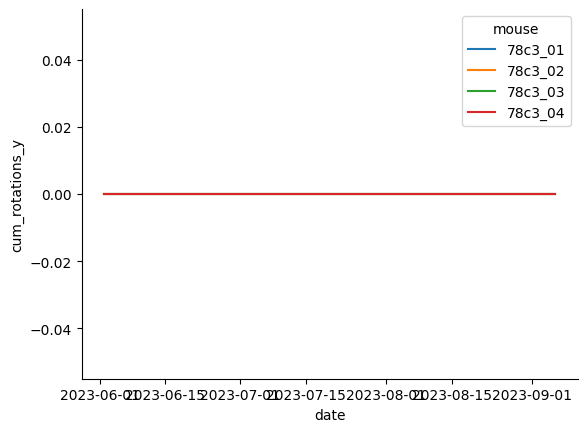

In [241]:
ax = sns.lineplot(
    data=wdf2[wdf2['cage']=='78c3'],
    x="date",
    y="cum_rotations_y",
    hue="mouse")
sns.despine()

In [242]:
wdf2.drop(['start','end','file','recording_duration_days','rotations_per_day'],axis=1,inplace=True)
wdf2.fillna(0, inplace=True)
wdf2['exp'] = wdf2['cage'].str[:3]

In [243]:
## save off the merged datafarme
data_folder = Path('/n/groups/datta/win/longtogeny/data/ontogeny/version_05')
wdf2.to_parquet(data_folder / "wheel_merged.parquet", engine='pyarrow') 